In [47]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

Написать программы (2 шт.), реализующие явную и неявную схемы
для уравнения

$$
\begin{array}{l}
u_t + (f(u))_x = 0 \\
u|_{t=0} = u_0(x) \\
x \in [a,b]
\end{array}
$$

Входные данные (которые могут быть изменены по указанию преподавателя):
    
    Нелинейность f (u) (для отладки можно взять f (u) = u^2);
    u0(x) (для отладки можно взять u0(x) = th(−x));
    Начало и конец отрезка и его длина;
    Краевые условия;
    Время окончания вычислений T , t ∈ [0, T ].



# Явная схема

In [48]:
def u_1_m(u, m, tau, h, F):
    return u[m] - (tau/h) * (F(u[m+1]) - F(u[m]))

def heat_expl(init, bound1, bound2, F, N, alpha, beta, tau, T):
    
    
    # YOUR CODE HERE
    w_x, h = np.linspace(alpha, beta, N+1, retstep=True)
    N_t = int(T / tau)
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    u_end = np.zeros(u_0.shape)
    
    for t0 in range(1, N_t+1):
        for m in range(1, N):
            u1m = u_1_m(u_0, m, tau, h, F)
            u1mm1 = u_1_m(u_0, m-1, tau, h, F)
            u_end[m] = 0.5 * (u_0[m] + u1m - (tau/h) * (F(u1m) - F(u1mm1)))
        u_end[0] = bound1(tau * t0)
        u_end[-1] = bound2(tau * t0)
        u_0 = u_end.copy()
    
    return w_x, u_end

In [76]:
def heat_expl_two_sided(init, bound1, bound2, F_u, N, alpha, beta, tau, T):
    
    
    # YOUR CODE HERE
    w_x, h = np.linspace(alpha, beta, N+1, retstep=True)
    N_t = int(T / tau)
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    u_end = np.zeros(u_0.shape)
    c = tau / h
    
    for t0 in range(1, N_t+1):
        u_end[0] = bound1(tau * t0)
        u_end[-1] = bound2(tau * t0)
        for m in range(1, N):
            fum = F_u(u_0[m])
            if fum > 0:
              u_end[m] = u_0[m] - fum * c * (u_0[m] - u_0[m-1])
            else:
              u_end[m] = u_0[m] - fum * c * (u_0[m+1] - u_0[m])    
        u_0 = u_end.copy()
        if t0 % 5 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(9,6))
            plt.plot(w_x, u_0)
            plt.title(fr'График функции в момент времени t = {t0} * $\Delta\tau$')
            plt.show()
    return w_x, u_end

In [ ]:
def F(u):
    return 2 * u

def F_u(u):
    return 2

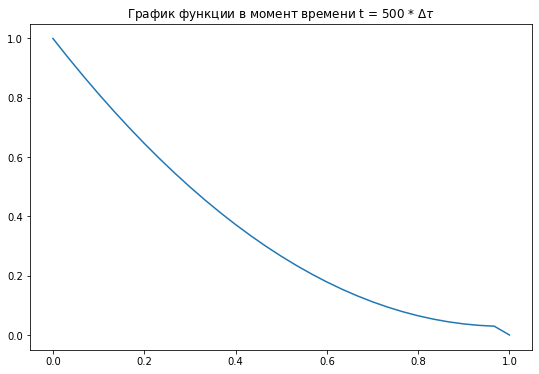

In [79]:
w_x, u_0 = heat_expl_two_sided(lambda x: x ** 2, 
                               lambda t: (0 - 2 * t) ** 2, 
                               lambda t: (1. - 2 * t) ** 2, 
                               lambda u: 2, 
                               30, alpha=0., beta=1., tau=0.001, T=0.5)

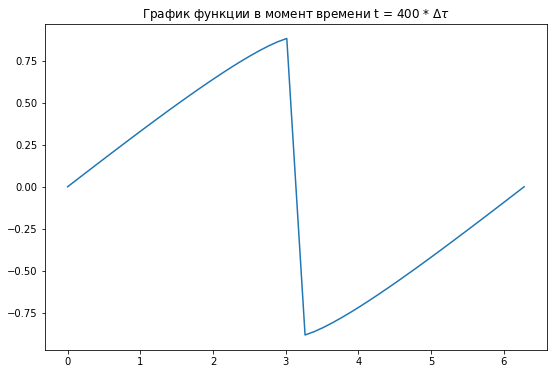

In [65]:
F_u = lambda u: u
w_x, u_0 = heat_expl_two_sided(lambda x: np.sin(x), lambda t: 0, lambda t:0, F_u, 50,
                     alpha=0., beta=2*np.pi, tau=0.005, T=2)

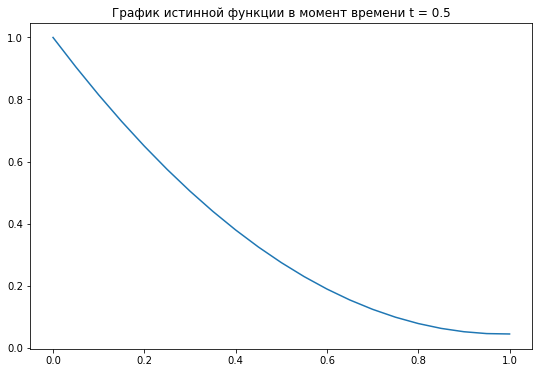

In [ ]:
x = w_x
T = 0.5
y = (w_x - 2 * T) ** 2
plt.figure(figsize=(9,6))
plt.plot(w_x, u_0)
plt.title(fr'График истинной функции в момент времени t = {T}')
plt.show()

# Неявная схема

In [ ]:
from scipy.linalg import solve_banded

def heat_impl(init, bound1, bound2, F, F_u, N, alpha, beta, tau, T):

    w_x, h = np.linspace(alpha, beta, N+1, retstep=True)
    N_t = int(T / tau)
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    u_end = np.zeros(u_0.shape)
    c = tau / (2*h)
    
    A = np.zeros((3, N - 1))
    
    for t0 in range(1, N_t+1):
        u_end[0] = bound1(tau * t0)
        u_end[-1] = bound2(tau * t0)
        

        A[0] = c * F_u(u_0[1:-1])
        A[1] = 1.
        A[2] = -A[0,:]
        b = u_0[1:-1]
        b[0] += u_end[0] * c * F_u(u_0[1])
        b[-1] -= u_end[-1] * c * F_u(u_0[-2])
        u_end[1:-1] = solve_banded((1,1), A, b)
        u_0 = u_end.copy()
        
    return w_x, u_end

In [ ]:
def heat_impl_danilov(init, bound1, F_u, N, alpha, beta, tau, T):

    # YOUR CODE HERE
    w_x, h = np.linspace(alpha, beta, N+1, retstep=True)
    N_t = int(T / tau)
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    u_end = np.zeros(u_0.shape)
    c = tau / h
    
    for t0 in range(1, N_t+1):
        u_end[0] = bound1(tau * t0)
        for m in range(1, N+1):
            f = F_u(u_0[m])
            u_end[m] = (u_0[m] + u_end[m-1] * f * c) / (1 + f * c)
        u_0 = u_end.copy()
        if t0 % 5 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(9,6))
            plt.plot(w_x, u_0)
            plt.title(fr'График функции в момент времени t = {t0} * $\Delta\tau$')
            plt.show()
    return w_x, u_end

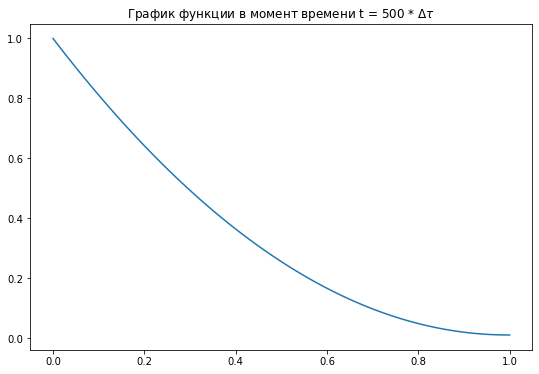

In [ ]:
w_x, u_0 = heat_impl_danilov(lambda x: x ** 2, lambda x: (0 - 2 * x) ** 2, F_u, 100,
                     alpha=0., beta=1., tau=0.001, T=0.5)